In [1]:
import numpy as np
import sys
sys.path.append('./../gp_sinkhorn/')
from SDE_solver import solve_sde_RK
from utils import plot_trajectories_2
import matplotlib.pyplot as plt
from MLE_drift import *
import torch

from celluloid import Camera
from IPython.display import HTML
import math

# Double well

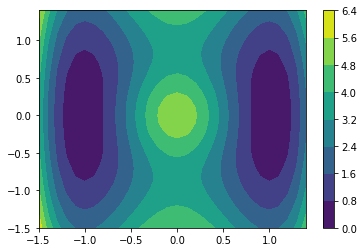

In [2]:
feature_x = np.arange(-1.5, 1.5, 0.1)
feature_y = np.arange(-1.5, 1.5, 0.1)
x, y = np.meshgrid(feature_x, feature_y)

delta = 0.35
fac = 1
z = (5/2.0)*(x**2-1)**2+y**2 +  fac*np.exp(-(  x**2 +y**2)/delta)/delta
 

#  -2 *x/delta*np.exp(-(  x**2 +y**2)/delta)/delta
#  (-( 2*y)/delta )*np.exp(-(  x**2 +y**2)/delta)/delta

h = plt.contourf(feature_x,feature_y,z)
plt.colorbar()
plt.show()



In [3]:
np.where(z.max() ==z)

(array([0], dtype=int64), array([0], dtype=int64))

In [4]:
z[10,10]

2.340967246976508

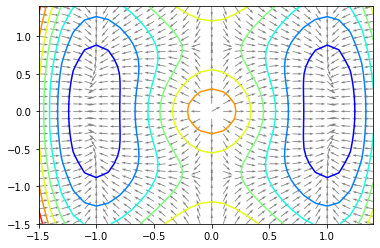

In [5]:
u = -(10*x*(x**2-1)) + fac* 2 * x * np.exp(-(  x**2 +y**2)/delta)/delta**2
v = -(2*y)  + fac * 2* y * np.exp(-(  x**2 +y**2)/delta)/delta**2

norm = np.linalg.norm(np.array((u, v)), axis=0)
u = (u / norm)*0.1
v = (v / norm)*0.1

fig, ax = plt.subplots(1, 1)

ax.quiver(x, y, u, v, units='xy', scale=1, color='gray')
ax.contour(x, y, z, 7, cmap='jet')


In [6]:
delta_tn = torch.tensor(delta)

deriv_x = lambda x,y: -(10*x*(x**2-1)) +  2 * x * torch.exp(-(  x**2 +y**2)/delta_tn)/delta_tn**2
deriv_y = lambda x,y: -(2*y) +2* y * torch.exp(-(  x**2 +y**2)/delta_tn)/delta_tn**2
# deriv_y = deriv_x
# prior_drift = lambda X: torch.tensor([[deriv_x(i[0]),deriv_y(i[1])] for i in X])

prior_drift = lambda X: torch.tensor([[deriv_x(i[0],i[1]),deriv_y(i[0],i[1])] for i in X])

In [17]:
num_samples=50
sigma = 0.5
dt = 0.05
N = int(math.ceil(1.0/dt))
mu_0 = torch.tensor([1.0,0.0])
X_0 = torch.distributions.multivariate_normal.MultivariateNormal(mu_0,torch.eye(2)*0.05).sample((num_samples,1)).reshape((-1,2)).double()
mu_1 = torch.tensor([-1.0,0.0])
X_1 = torch.distributions.multivariate_normal.MultivariateNormal(mu_1,torch.eye(2)*0.05).sample((num_samples,1)).reshape((-1,2)).double()

mu_2 = torch.tensor([0.0,0.0])
X_2 = torch.distributions.multivariate_normal.MultivariateNormal(mu_2,torch.eye(2)*0.5).sample((150,1)).reshape((-1,2))

prior_X_0 = X_2.double()
t, Xts = solve_sde_RK(b_drift=prior_drift,sigma=sigma, X0=prior_X_0, dt=dt, N=N)
#plot_trajectories_2(Xts, t, remove_time=True)

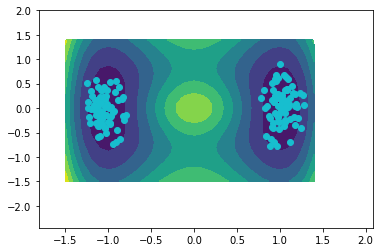

In [18]:
fig = plt.figure()
camera = Camera(fig)
for i in range(N):    
    plt.contourf(feature_x,feature_y,z)
    plt.scatter(Xts[:,i,0].detach(),Xts[:,i,1].detach())
    camera.snap()
animation = camera.animate()
HTML(animation.to_html5_video())
#animation.save('animation.mp4')



In [19]:
N

20

In [20]:
# sparse enables the nystrom method which is just a low rank approximation of the kernel matrix using
# random subsampling, should not affect interpretability much, ive tested it in all our experiments
# works surprisingly well

sigma= 2 # Works at 1.5 breaks at 0.5, what to do ?
sigma_target = 0.15

mod = 1
iteration = 25

increments = int(iteration / mod)
#  sigma_target =  sigma * decay_sigma**iteration 
decay_sigma = (sigma_target/sigma)**(1.0/increments)

sigma_test = sigma
for i in range(increments):
    sigma_test *= decay_sigma
    print(sigma_test)


1.8031524495915348
1.6256793782339762
1.4656738765565187
1.3214167204076037
1.1913578981670914
1.0740999562101066
0.968382983573207
0.8730710744863935
0.7871401233138269
0.7096668207625548
0.6398187331259186
0.5768453579652764
0.5200700601252969
0.4688828014370729
0.42273358599129957
0.38112655055241274
0.34361463661647745
0.3097947868652532
0.27930361440338436
0.251813498245616
0.22702906310089807
0.20468400562942773
0.18453823307145506
0.16637528350304387
0.1499999999999998


In [13]:
decay_sigma

0.9015762247957674

In [21]:

result = MLE_IPFP(
    X_0,X_1,N=N,sigma=0.5,
    prior_drift=prior_drift, sparse=False, 
    prior_X_0=prior_X_0, iteration=5, refinement_iterations=0,
    decay_sigma=1, gp_mean_prior_flag=True
)


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:20<00:00, 16.06s/it]


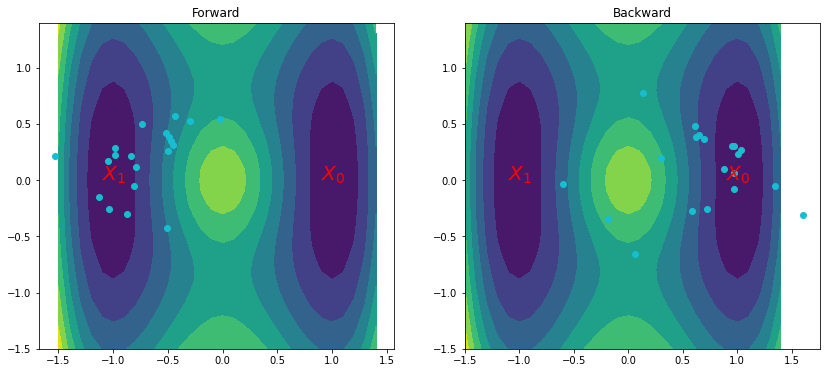

In [15]:


fig, (ax1, ax2) =  plt.subplots(1, 2,figsize=(14,6))
camera = Camera(fig)
M = result[-1][1]
M2 = result[-1][3]
for i in range(N):    
    ax1.contourf(feature_x,feature_y,z)
    ax2.contourf(feature_x,feature_y,z)
    ax1.scatter(M[:,i,0].detach(),M[:,i,1].detach())
    ax2.scatter(M2[:,i,0].detach(),M2[:,i,1].detach())
    ax1.set_title("Forward")
    ax2.set_title("Backward")
    
    ax1.text(0.9, 0, r'$X_0$', fontsize=20,color='red')
    ax2.text(0.9, 0, r'$X_0$', fontsize=20,color='red')
    ax1.text(-1.1, 0, r'$X_1$', fontsize=20,color='red')
    ax2.text(-1.1, 0, r'$X_1$', fontsize=20,color='red')

    camera.snap()
animation = camera.animate()
HTML(animation.to_html5_video())
#animation.save('animation.mp4')

Text(-1.1, 0, '$X_1$')

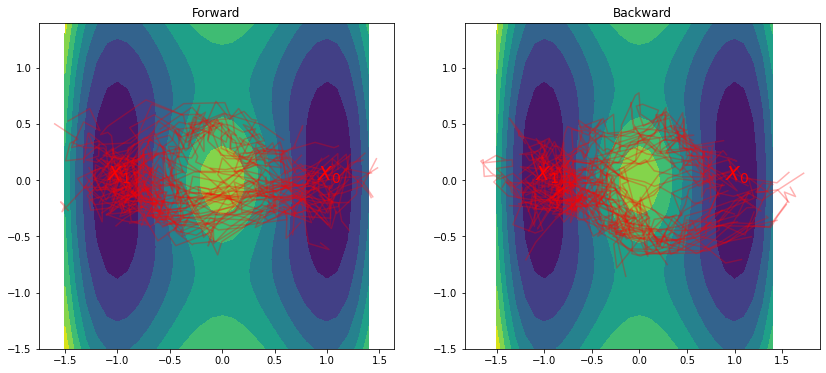

In [22]:
fig, (ax1, ax2) =  plt.subplots(1, 2,figsize=(14,6))

M = result[-1][1]
M2 = result[-1][3]
for i in range(len(M)): 
   
    ax1.contourf(feature_x,feature_y,z)
    ax2.contourf(feature_x,feature_y,z)

    μ10 = M[i,:,0].detach()#.mean(axis=0)
    μ11 = M[i,:,1].detach()#.mean(axis=0)
#     σ10 = M[i,:,0].detach().std(axis=0)
#     σ11 = M[i,:,1].detach().std(axis=0)

    μ20 = M2[i,:,0].detach()#.mean(axis=0)
    μ21 = M2[i,:,1].detach()#.mean(axis=0)
#     σ20 = M2[i,:,0].detach().std(axis=0)
#     σ21 = M2[i,:,1].detach().std(axis=0)

    ax1.plot(μ10, μ11, alpha=.3, color="red")
    ax2.plot(μ20, μ21, alpha=.3, color="red")

# ax1.plot(μ10, μ11 + 2*σ11)

# ax1.fill_between( μ11-2*σ11, μ11+2*σ11, alpha=.5)

# ax2.fill_between(μ20-2*σ20, μ21+2*σ21, alpha=.5)



ax1.set_title("Forward")
ax2.set_title("Backward")

ax1.text(0.9, 0, r'$X_0$', fontsize=20,color='red')
ax2.text(0.9, 0, r'$X_0$', fontsize=20,color='red')
ax1.text(-1.1, 0, r'$X_1$', fontsize=20,color='red')
ax2.text(-1.1, 0, r'$X_1$', fontsize=20,color='red')


In [22]:
import pandas as pd

pd.to_pickle(result, "nice_well_trajectory_20_iters_both_prior_bug_fix.pkl")

In [23]:
result_=pd.read_pickle("nice_well_trajectory_20_iters_both_prior_bugfix.pkl")